# **IMAGE CAPTIONING**

**Design a CNN-LSTM system that can perform image captioning**

Generating a caption for a given image is a challenging problem in the deep learning domain. In this project, I will use different techniques of computer vision and NLP to recognize the context  of  an  image  and  describe  them  in  a  natural  language  like  English.  we  will  build  a working  model  of  the  image  caption  generator  by  using  CNN  (Convolutional  Neural Networks) and LSTM(Longshort-termmemory) units.

*Solution By: Ashutosh Soni*

### **Importing Libraries**

In [ ]:
import numpy as np
import os
import string
import matplotlib.pyplot as plt
from PIL import Image
from pickle import dump, load

import torch
import torchvision.models as models
import torch.nn as nn

In [ ]:
image_directory = './images'

captions_file = './Flickr8k_text/Flickr8k.lemma.token.txt'
train_image_file = './Flickr8k_text/Flickr_8k.trainImages.txt'
val_image_file = './Flickr8k_text/Flickr_8k.valImages.txt'
test_image_file = './Flickr8k_text/Flickr_8k.testImages.txt'

preprocessed_text = './preprocessed/descriptions.txt'

### **Helper Functions for Text Preprocessing**

In [ ]:
def get_file_content(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def get_caption_dictionary(filename):
    content = get_file_content(filename)
    captions = content.split('\n')
    descriptions = {}
    for cap in captions[:-1]:
        img, desc = cap.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [desc]
        else:
            descriptions[img[:-2]].append(desc)
    return descriptions

def cleaning(descriptions):
    table = str.maketrans('','',string.punctuation)
    for img, caps in descriptions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            descriptions[img][i]= '<start> ' + img_caption + ' <end>'
    return descriptions

def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def generate_word_to_id(desc_list):
    vocab = set()
    for desc in desc_list:
        for w in desc.split(" "):
            vocab.add(w)
    
    word_to_id = {w:i for i, w in enumerate(vocab)}
    id_to_word = {i:w for i, w in enumerate(vocab)}
    
    return word_to_id, id_to_word

def generate_tokens(descriptions):
    desc_list = dict_to_list(descriptions)
    word_to_id, id_to_word = generate_word_to_id(desc_list)
    return word_to_id, id_to_word

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

def save_preprocessed_descriptions(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        for cap in desc:
            lines.append(key+'\t'+cap)
    text = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(text)
    file.close()

In [ ]:
descriptions = get_caption_dictionary(captions_file)
preprocess_descriptions = cleaning(descriptions)

In [ ]:
word_to_id, id_to_word = generate_tokens(preprocess_descriptions)
vocab_size = len(word_to_id)
print("Vocabulary size: ", vocab_size)

Vocabulary size:  6689


### **Image Preprocessing**

In [ ]:
class ImagePreprocessing:
    def __init__(self, hidden_size):
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50_without_top = torch.nn.Sequential(*(list(self.resnet50.children())[:-1]))

        self.cnn_top = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(2048, hidden_size)
        )

    def image_feature_extraction(self, img):
        file = './images/'+img
        image = Image.open(file)
        image_resized = image.resize((250, 250))
        image_input = np.expand_dims(image_resized, axis=0)
        image_input = image_input/127.5
        image_input = image_input - 1.0
        input = torch.from_numpy(image_input)
        feature = self.resnet50_without_top(input.permute(0, 3, 1, 2).float())
        feature_cnn = self.cnn_top(feature)
        return feature_cnn

**List of Train, Test and Validation images**

In [ ]:
## Train Images
train_images = []

file_cont = get_file_content(train_image_file)
for img in file_cont.split('\n'):
    train_images.append(img)

## Test Images
test_images = []
file_cont = get_file_content(test_image_file)
for img in file_cont.split('\n'):
    test_images.append(img)

## Validation Images
val_images = []
file_cont = get_file_content(val_image_file)
for img in file_cont.split('\n'):
    val_images.append(img)
print(len(train_images), len(test_images), len(val_images))

6001 1001 1001


### **Image Captioning Model Definition**


- forward(captions, feature): perform the forward propogation(for training);

  - **captions** represent a caption for image whose feature is passed in the **feature**
- predict(start, feature, length): perform the prediction(internally forward propogation for test); 
  - **start** represent the starting tag of caption, 
  - **feature** represent the test image features and 
  - **length** represent the length of the caption which needs to predicted

In [ ]:
class image_caption(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(image_caption, self).__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = 1

        ## Defining LSTM related layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(input_size=embed_size, hidden_size=hidden_size)

        self.output = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.y_hat = nn.LogSoftmax(dim=1)

    def forward(self, captions, feature):
        outputs = torch.empty((1, captions.size(1), self.vocab_size))
        
        hidden_state = torch.from_numpy(feature)
        cell_state = torch.zeros((1, self.hidden_size))
        
        embedding = self.embedding(captions)
        
        for t in range(captions.size(1)):
            hidden_state, cell_state = self.lstm(embedding[:, t, :], (hidden_state, cell_state))           
        
            out = self.output(hidden_state)
            tanh = self.tanh(out)
            output = self.y_hat(tanh)
            
            outputs[:, t, :] = output
        return outputs
    
    def predict(self, start, feature, length):
        outputs = torch.empty((1, length))
        
        hidden_state = torch.from_numpy(feature)
        cell_state = torch.zeros((1, self.hidden_size))
        
        word = torch.from_numpy(np.expand_dims(np.array(start), axis=0))
        
        for t in range(length):
            embedding = self.embedding(word)
            print(embedding.shape)
            hidden_state, cell_state = self.lstm(embedding[:, 0, :], (hidden_state, cell_state))           
        
            out = self.output(hidden_state)
            tanh = self.tanh(out)
            output = self.y_hat(tanh)
            
            curr_index = np.argmax(output.detach().numpy())
            outputs[:, t] = curr_index
            word = torch.from_numpy(np.expand_dims(np.array([curr_index]), axis=0))
        return outputs

    def initHC(self, hidden_init):
        state_c = torch.zeros(1, self.hidden_size)
        return (torch.from_numpy(hidden_init), state_c)

### **Data Generator**

In [ ]:
def create_sequences(word_to_id, desc, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    in_seq = []
    for w in desc.split(" "):
        in_seq.append(word_to_id[w])
        
    out_seq = in_seq[1:]
    out_seq.append(word_to_id[''])
        
    f_array = np.expand_dims(np.array(feature.detach().numpy()[0]), axis=0)
    input_seq = np.expand_dims(np.array(in_seq), axis=0)
    output_seq = np.expand_dims(np.array(out_seq), axis=0)
        
    return f_array, input_seq, output_seq


# create_sequences(tokenizer, max_length, preprocess_descriptions[train_images[0]], feature)
def data_generator(descriptions, image, feature, word_to_id):
    description_list=descriptions[image]
    for desc in description_list:
        input_image, input_sequence, output_word = create_sequences(word_to_id, desc, feature)
        yield [input_image, input_sequence, output_word]

### **Model Training**

**Initialization of Hyper-parameters**

In [ ]:
vocabulary_size = vocab_size
embed_size = 512
hidden_size = 1024
sequence_length = max_length

**Initialisation of captioning model**

In [ ]:
cap_model = image_caption(vocabulary_size, embed_size, hidden_size)
cap_model

image_caption(
  (embedding): Embedding(6689, 512)
  (lstm): LSTMCell(512, 1024)
  (output): Linear(in_features=1024, out_features=6689, bias=True)
  (tanh): Tanh()
  (y_hat): LogSoftmax(dim=1)
)

**Initialisation of loss function and optimizer for the PyTorch Model**

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.Adam(cap_model.parameters(), lr=learning_rate)

**Training**

In [ ]:
image_prep = ImagePreprocessing(hidden_size)
for epoch in range(1):
    loss = 0
    for i in range(len(train_images)):
        image_name = train_images[i]
        if image_name not in os.listdir('./images'):
            continue
            
        feature = image_prep.image_feature_extraction(image_name)

        data_gen = data_generator(preprocess_descriptions, image_name, feature, word_to_id)

        for _, input in enumerate(data_gen):
            optimizer.zero_grad()

            y_pred = cap_model.forward(torch.from_numpy(input[1]), input[0])
            
            loss +=  cross_entropy(y_pred.transpose(1, 2), torch.from_numpy(input[2]).type(torch.LongTensor))

        if i%24 == 0:
            loss.backward()
            optimizer.step()
            print("Epoch {}, batch {} and loss {}".format(epoch+1, i/24, loss))
            loss = 0
        
        if i%50==0:
          print("Saving Model...")
          torch.save(cap_model, "captioning.pth")

Epoch 1, batch 0.0 and loss 37.81504440307617
Saving Model...
Epoch 1, batch 1.0 and loss 961.4395751953125
Epoch 1, batch 2.0 and loss 935.2728881835938
Saving Model...
Epoch 1, batch 3.0 and loss 949.349853515625
Epoch 1, batch 4.0 and loss 921.9692993164062
Saving Model...
Epoch 1, batch 5.0 and loss 820.3671264648438
Epoch 1, batch 6.0 and loss 897.4667358398438
Saving Model...
Epoch 1, batch 7.0 and loss 903.4552612304688
Epoch 1, batch 8.0 and loss 894.5794677734375
Saving Model...
Epoch 1, batch 9.0 and loss 819.3464965820312
Epoch 1, batch 10.0 and loss 888.6200561523438
Saving Model...
Epoch 1, batch 11.0 and loss 862.6766357421875
Epoch 1, batch 12.0 and loss 848.3878173828125
Saving Model...
Epoch 1, batch 13.0 and loss 861.8150024414062
Epoch 1, batch 14.0 and loss 814.218017578125
Saving Model...
Epoch 1, batch 15.0 and loss 888.56494140625
Epoch 1, batch 16.0 and loss 886.1998901367188
Saving Model...
Epoch 1, batch 17.0 and loss 887.0767211914062
Epoch 1, batch 18.0 and 

### **Testing**

**Loading test image**

In [ ]:
image = train_images[0]
test_feature = image_prep.image_feature_extraction(image)

test_input = [word_to_id['<start>']]

test_pred = cap_model.predict(test_input, np.expand_dims(np.array(test_feature.detach().numpy()[0]), axis=0), 5)

torch.Size([1, 1, 512])
torch.Size([1, 1, 512])
torch.Size([1, 1, 512])
torch.Size([1, 1, 512])
torch.Size([1, 1, 512])


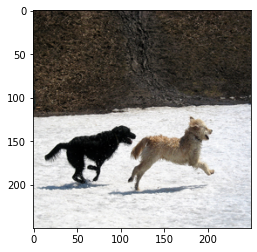

In [ ]:
test_image = Image.open('./images/'+image)
test_image_resized = test_image.resize((250, 250))
plt.imshow(test_image_resized)
plt.show()

**prediction**

In [ ]:
test_caption = "<start> "
for word_ind in test_pred.detach().numpy()[0]:
    print(word_ind)
    test_caption += id_to_word[word_ind]
    test_caption += " "        
print(test_caption)

3019.0
5133.0
5133.0
5133.0
320.0
<start> two dog dog dog in 


**BLEU score**

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
test_description_list=descriptions[image]
reference = [[w for w in desc.split(" ")] for desc in test_description_list]
inference = [w for w in test_caption.split(" ")]
score = sentence_bleu(reference, inference)
print(score)

0.3884935863283276


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
